# 프로젝트: 머신러닝을 이용한 텍스트 분류
* 사용 데이터셋: Tensorflow에서 제공하는 로이터 뉴스 데이터


In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import os
import random
import tensorflow as tf

warnings.filterwarnings(action='ignore') 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
# from sklearn.svm import LinearSVC # 이진 분류에서만 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score #정확도 계산
from keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import RandomizedSearchCV

> random_state: int, RandomState instance or None, default=None
Controls the pseudo random number generation for shuffling the data for the dual coordinate descent (if dual=True). When dual=False the underlying implementation of LinearSVC is not random and random_state has no effect on the results. Pass an int for reproducible output across multiple function calls. See Glossary.

In [4]:
# random seed 설정
def set_seeds(seed):
    os.environ['PYTHONHASHRANDOMSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

## 데이터 로드 및 출력

In [77]:
!mkdir -p /content/aiffel/reuters_classifiaction

mkdir: cannot create directory ‘/content’: Permission denied


In [78]:
!pwd

/home/aiffel-dj19/aiffel/reuters_classifiaction


In [79]:
file_path = os.getenv('HOME') +  '/aiffel/reuters_classifiaction'
file_path

'/home/aiffel-dj19/aiffel/reuters_classifiaction'

## Vocab size = 10000개 사용

### 로이터 뉴스 데이터 로드 

In [90]:
vocab_size=10000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

In [91]:
# 데이터 개수 확인
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [92]:
# 훈련/시험 데이터 값 일부 확인
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [93]:
try:
    y_train.unique() # unique는 array에 적용 가능
except:
    print("Type이 맞지 않습니다.")

Type이 맞지 않습니다.


In [94]:
# label값 확인
print(set(y_train)) # list이므로 set으로 중복 제거 
print(set(y_test))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45}


In [95]:
# label = class의 수 확인 
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


In [96]:
y_train.min(), y_train.max()

(0, 45)

### 데이터 분포 확인

In [97]:
def show_dist(x_, y_):
    # histogram으로 x 데이터 분포 확인 
    print('----------------------------------------')
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_))/len(x_)))

    plt.figure(figsize=(5, 3))
    plt.hist([len(s) for s in x_], bins=80)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title('Sentence Length Distribution')
    plt.tight_layout()
    plt.show()

    # histogram으로 y 라벨 데이터 분포 확인
    print('----------------------------------------')
    print('가장 큰 Label Index :{}'.format(max(l for l in y_)))
    print('가장 작은 Label Index :{}'.format(min(l for l in y_)))

    plt.figure(figsize=(5, 3))
    plt.hist([c for c in y_], bins=80)
    plt.xlabel('index of labels')
    plt.ylabel('number of samples')
    plt.title('Label Distribution')
    plt.tight_layout()
    plt.show()

    # bar로 y 라벨 데이터 분포 확인
    index_labels = np.zeros((num_classes), dtype=np.int)

    for cnt in y_:
        index_labels[cnt-1] += 1

    print('----------------------------------------')
    print('가장 많은 Label :{}'.format(index_labels.argmax(axis=0)))
    print('가장 적은 Label :{}'.format(index_labels.argmin(axis=0)))

    unique_elements, counts_elements = np.unique(y_train, return_counts=True)
    
    print("각 클래스 빈도수:")
    print(np.asarray((unique_elements, counts_elements)))

    plt.figure(figsize=(5, 3))
    plt.bar(range(num_classes), index_labels, width=1.0)
    plt.title("Label Distribution")
    plt.tight_layout()
    plt.show()

----------------------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


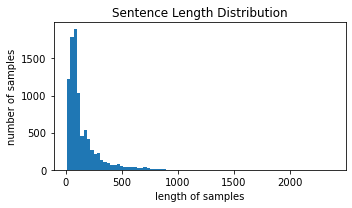

----------------------------------------
가장 큰 Label Index :45
가장 작은 Label Index :0


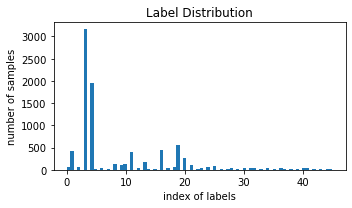

----------------------------------------
가장 많은 Label :2
가장 적은 Label :34
각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


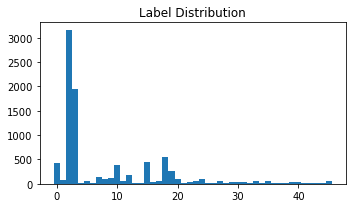

In [98]:
show_dist(x_train, y_train)

=> 2번, 3번 클래스가 2000개 이상으로 가장 많이 분포하고 있습니다.

----------------------------------------
훈련용 뉴스의 최대 길이 :1032
훈련용 뉴스의 평균 길이 :147.66117542297417


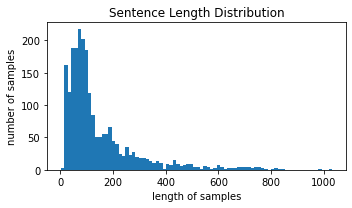

----------------------------------------
가장 큰 Label Index :45
가장 작은 Label Index :0


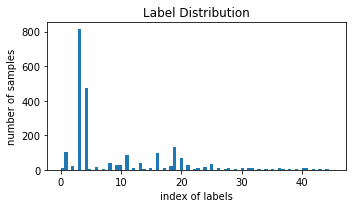

----------------------------------------
가장 많은 Label :2
가장 적은 Label :44
각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


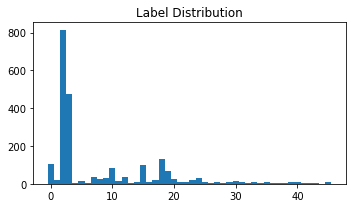

In [99]:
show_dist(x_test, y_test)

### 원본 뉴스 데이터로 복원

In [100]:
def encode_index(word_index_):
    encoded = {index + 3 : word for word, index in word_index_.items()}

    # index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        encoded[index]=token
        
    return encoded

In [101]:
def decode_index(corpus, index_to_word_):
    decoded = []
    for i in range(len(corpus)):
        t = ' '.join([index_to_word_[index] for index in corpus[i]])
        decoded.append(t)
    return decoded

In [102]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [103]:
index_to_word = encode_index(word_index)

In [104]:
print(word_index['0'])
print(word_index['the'])
print(word_index['it'])
print(index_to_word[0])
print(index_to_word[1])
print(index_to_word[2])
print(index_to_word[4])
print(index_to_word[16])

67
1
13
<pad>
<sos>
<unk>
the
it


In [105]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [106]:
decoded_x_train = decode_index(x_train, index_to_word)
decoded_x_train[0]

'<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [107]:
decoded_x_test = decode_index(x_test, index_to_word)
decoded_x_test[0]

'<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3'

### 벡터화: DTM & TF-IDF

In [108]:
def dtm_to_tfidf(x_train_, x_test_):
    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()
    
    x_train_dtm = dtmvector.fit_transform(x_train_) # 데이터를 DTM으로 변환
    x_train_tfidfv = tfidf_transformer.fit_transform(x_train_dtm) # DTM을 TF-IDF 행렬로 변환
    
    x_test_dtm = dtmvector.transform(x_test_) # 데이터를 DTM으로 변환
    x_test_tfidfv = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
    
    print('shape of dtm: ', x_train_dtm.shape)
    print('shape of tfidfv: ', x_train_tfidfv.shape)
    print('shape of dtm: ', x_test_dtm.shape)
    print('shape of tfidfv: ', x_test_tfidfv.shape)
    
    return x_train_tfidfv, x_test_tfidfv

In [109]:
tfidfv_train, tfidfv_test = dtm_to_tfidf(decoded_x_train, decoded_x_test)

shape of dtm:  (8982, 9670)
shape of tfidfv:  (8982, 9670)
shape of dtm:  (2246, 9670)
shape of tfidfv:  (2246, 9670)


### ML 모델 구현 
* Naive Bayes Classifier
* Complement Naive Bayes Classifier(CNB)
* 로지스틱 회귀(Logistic Regression)
* 선형 서포트 벡터 머신 => 서포트 벡터 머신 사용(다중분류는 Linear 잘 사용 안함)
* 결정 트리(Decision Tree)
* 랜덤 포레스트(Random Forest)
* 그래디언트 부스팅 트리(GradientBoostingClassifier)
* 보팅(Voting)

#### 모델 훈련, 예측 및 시각화

In [110]:
def fit_predict(x_train_, y_train_, x_test_, y_test_):
    nb = MultinomialNB()
    nb.fit(x_train_, y_train_)
    nb_predicted = nb.predict(x_test_) #테스트 데이터에 대한 예측
    print("MultinomialNB 정확도:", accuracy_score(y_test_, nb_predicted)) #예측값과 실제값 비교
    
    cb = ComplementNB()
    cb.fit(x_train_, y_train_)
    cb_predicted = cb.predict(x_test_) #테스트 데이터에 대한 예측
    print("ComplementNB 정확도:", accuracy_score(y_test_, cb_predicted)) #예측값과 실제값 비교
    
    lr = LogisticRegression(C=10000, 
                            penalty='l2',
                            random_state=RANDOM_SEED)
    lr.fit(x_train_, y_train_)
    lr_predicted = lr.predict(x_test_) #테스트 데이터에 대한 예측
    print("LogisticRegression 정확도:", accuracy_score(y_test_, lr_predicted)) #예측값과 실제값 비교

    n_estimators = 500
    
    svc = SVC(kernel='rbf', 
              probability=True,
              random_state=RANDOM_SEED)
#               SVC(C=1000, 
#               penalty='l1', 
#               max_iter=n_estimators, 
#               dual=False) # dual=False이면 Random하지 않다.
    svc.fit(x_train_, y_train_)
    svc_predicted = svc.predict(x_test_) #테스트 데이터에 대한 예측
    print("SVC 정확도:", accuracy_score(y_test_, svc_predicted)) #예측값과 실제값 비교

    tree = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_SEED)
    tree.fit(x_train_, y_train_)
    tree_predicted = tree.predict(x_test_) #테스트 데이터에 대한 예측
    print("DecisionTreeClassifier 정확도:", accuracy_score(y_test_, tree_predicted)) #예측값과 실제값 비교

    forest = RandomForestClassifier(n_estimators=n_estimators,
                                      random_state=RANDOM_SEED, 
                                      verbose=0)
    forest.fit(x_train_, y_train_)
    forest_predicted = forest.predict(x_test_) #테스트 데이터에 대한 예측
    print("RandomForestClassifier 정확도:", accuracy_score(y_test_, forest_predicted)) #예측값과 실제값 비교

    grbt = GradientBoostingClassifier(n_estimators=n_estimators,
                                      random_state=RANDOM_SEED, 
                                      verbose=0, 
                                      validation_fraction=0.2,
                                      n_iter_no_change=3, 
                                      tol=0.01) # verbose=3
    grbt.fit(x_train_, y_train_)
    grbt_predicted = grbt.predict(x_test_) #테스트 데이터에 대한 예측
    print("GradientBoostingClassifier 정확도:", accuracy_score(y_test_, grbt_predicted)) #예측값과 실제값 비교

    voting_classifier = VotingClassifier(estimators=[
             ('lr', LogisticRegression(C=10000, 
                                       penalty='l2', 
                                       random_state=RANDOM_SEED)),
            ('cb', ComplementNB()),
            ('grbt', GradientBoostingClassifier(n_estimators=n_estimators,
                                      random_state=RANDOM_SEED, 
                                      verbose=0, 
                                      validation_fraction=0.2,
                                      n_iter_no_change=3, 
                                      tol=0.01)) #
    ], voting='soft', n_jobs=-1)
    voting_classifier.fit(x_train_, y_train_)
    voting_classifier_predicted = voting_classifier.predict(x_test_) #테스트 데이터에 대한 예측
    print("VotingClassifier 정확도:", accuracy_score(y_test_, voting_classifier_predicted)) #예측값과 실제값 비교
    
    return {'MultinomialNB':nb, 'ComplementNB':cb, 'LogisticRegression':lr, 'SVC':svc,
           '':tree, 'RandomForestClassifier':forest, 'GradientBoostingClassifier':grbt, 'VotingClassifier':voting_classifier}

In [111]:
model_dict = fit_predict(tfidfv_train, y_train, tfidfv_test, y_test)

MultinomialNB 정확도: 0.6567230632235085
ComplementNB 정확도: 0.7707034728406055
LogisticRegression 정확도: 0.8076580587711487
SVC 정확도: 0.804986642920748
DecisionTreeClassifier 정확도: 0.6219946571682992
RandomForestClassifier 정확도: 0.7586821015138023
GradientBoostingClassifier 정확도: 0.7377560106856634
VotingClassifier 정확도: 0.8094390026714159


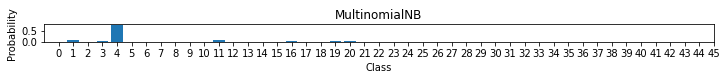

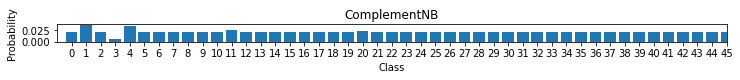

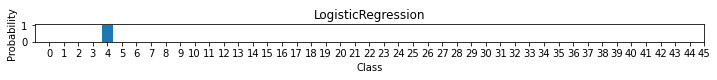

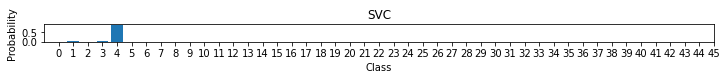

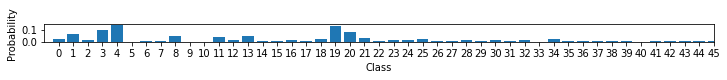

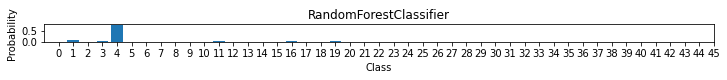

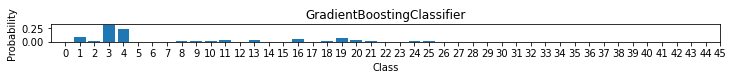

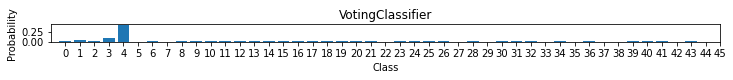

In [112]:
for key, model in model_dict.items():
    plot_idx = 1
    plt.subplot(len(model_dict),1,plot_idx)
    plt.title(key)
    plt.rcParams["figure.figsize"] = (12,3)
    plt.bar(model.classes_, model.predict_proba(tfidfv_train[3])[0])
    plt.xlim(-1, 21)
    plt.xticks(model.classes_)
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.tight_layout() # 촘촘한 그래프를 보기 좋게 재구성
    plt.show()
    plot_idx += 1

#### Confusion Matrix: Accuracy & F1-score

In [113]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(5,5))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

MultinomialNB  Confusion Matrix
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61      

SVC  Confusion Matrix
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.63      0.83      0.72       105
           2       0.81      0.65      0.72        20
           3       0.93      0.94      0.94       813
           4       0.73      0.93      0.81       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.76      0.66      0.70        38
           9       0.81      0.84      0.82        25
          10       0.96      0.80      0.87        30
          11       0.67      0.77      0.72        83
          12       0.80      0.31      0.44        13
          13       0.66      0.57      0.61        37
          14       1.00      0.50      0.67         2
          15       0.00      0.00      0.00         9
          16       0.74      0.77      0.75        99
     

VotingClassifier  Confusion Matrix
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.78      0.72      0.75       105
           2       0.73      0.80      0.76        20
           3       0.92      0.94      0.93       813
           4       0.83      0.87      0.85       474
           5       0.50      0.20      0.29         5
           6       0.86      0.86      0.86        14
           7       1.00      0.67      0.80         3
           8       0.71      0.71      0.71        38
           9       0.81      0.84      0.82        25
          10       0.90      0.90      0.90        30
          11       0.64      0.69      0.66        83
          12       0.46      0.46      0.46        13
          13       0.66      0.62      0.64        37
          14       0.25      1.00      0.40         2
          15       0.67      0.44      0.53         9
          16       0.72      0.74      0.73   

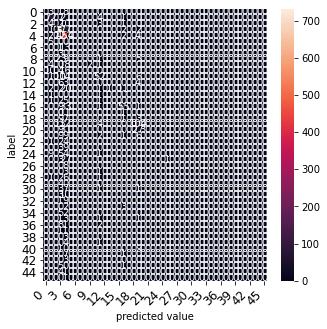

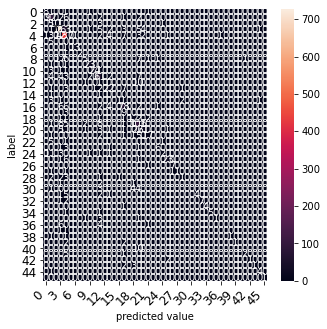

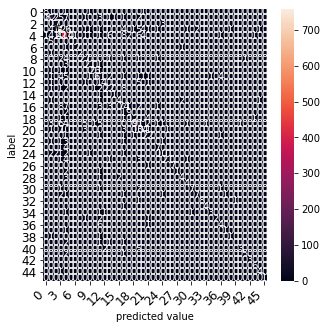

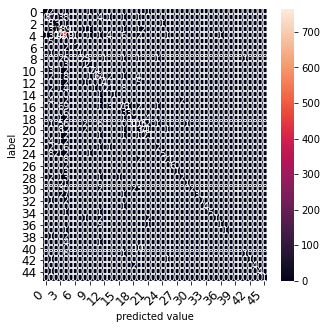

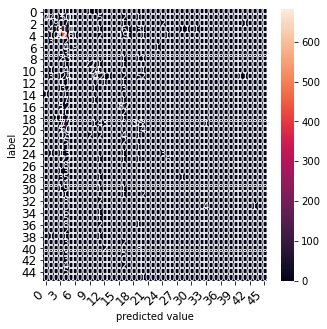

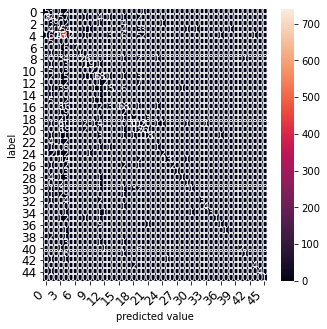

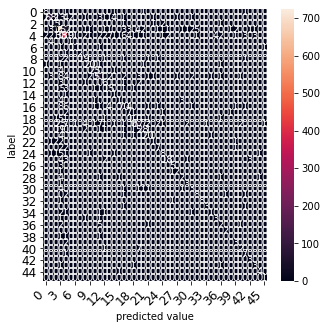

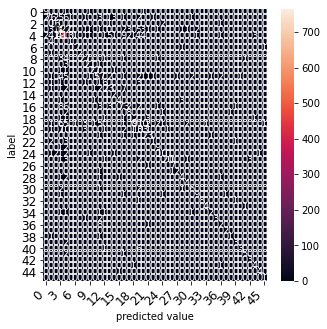

In [114]:
for key, model in model_dict.items():
    print(key, ' Confusion Matrix')
    print(classification_report(y_test, model.predict(tfidfv_test)))
    graph_confusion_matrix(model, tfidfv_test, y_test)

### DL 모델

In [115]:
word_vector_dim = 64
word_vector_dim

64

In [116]:
vocab_size

10000

In [117]:
num_classes

46

`입력 데이터에 대한 오류가 계속 떴는데 @리뉴킴님께서 todense로 바꿔줘야 딥러닝 모델에서 돌아간다는 선견지명을 주셔서 [링크](https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required)를 참고했습니다. `
    
toarray와 todense의 차이: https://rfriend.tistory.com/551

In [118]:
tfidfv_train = tfidfv_train.toarray() # slicing을 위해 array 사용 

In [119]:
tfidfv_test = tfidfv_test.toarray()

In [120]:
y_train = keras.utils.to_categorical(y_train) # softmax와 비교를 위해 그리고 손실함수 = categorical 이므로 원핫벡터로 표현
y_test = keras.utils.to_categorical(y_test)

In [121]:
y_train.argmax(axis=1)

array([ 3,  4,  3, ..., 25,  3, 25])

In [122]:
vocab_size = tfidfv_train.shape[1]

validation dataset을 구분하는 거 보다, 그냥 단순히 validation split으로 할당해주는게 더 정확도가 높았습니다.

In [123]:
# x_val = tfidfv_train[:1000]
# partial_x_train = tfidfv_train[1000:]

# y_val = y_train[:1000]
# partial_y_train = y_train[1000:]

In [137]:
from keras import backend as K

# F1-score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [141]:
# mlp
mlp = keras.models.Sequential()
mlp.add(keras.layers.Dense(64, activation='relu', input_shape=(vocab_size,)))
mlp.add(keras.layers.Dense(64, activation='relu'))
mlp.add(keras.layers.Dense(num_classes, activation='softmax'))
mlp.summary()

# # mlp
# fcn = keras.models.Sequential()
# fcn.add(keras.layers.Flatten(input_shape=(vocab_size,)))
# fcn.add(keras.layers.Dense(128, activation='relu'))
# fcn.add(keras.layers.Dense(num_classes, activation='softmax'))
# fcn.summary()

# # maxpl
# maxpl = keras.Sequential()
# maxpl.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# maxpl.add(keras.layers.GlobalMaxPooling1D())
# maxpl.add(keras.layers.Dense(128, activation='relu'))
# maxpl.add(keras.layers.Dense(num_classes, activation='softmax'))
# maxpl.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                618944    
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 46)                2990      
Total params: 626,094
Trainable params: 626,094
Non-trainable params: 0
_________________________________________________________________


* 다중 분류 문제에서 사용하는 손실 함수     
    1. categorical_crossentropy
    - 입력: One-hot vector
    - 출력: one-hot encoding 결과 
    - 클래스가 상호 배타적일 경우 

    2. sparse categorical crossentropy 
    - 입력: 정수 
    - 출력: 정수
    - 한 샘플에 여러 클래스가 있거나 label이 softmax 확률일 경우 사용 

Epoch 1/30
 98/113 [=========================>....] - ETA: 0s - loss: 3.3715 - accuracy: 0.4759
Epoch 00001: val_accuracy improved from -inf to 0.51753, saving model to /home/aiffel-dj19/aiffel/reuters_classifiaction/model/best_mlp.h5
113/113 [==============================] - 1s 5ms/step - loss: 3.2341 - accuracy: 0.4721 - val_loss: 2.2060 - val_accuracy: 0.5175
Epoch 2/30
113/113 [==============================] - ETA: 0s - loss: 1.8403 - accuracy: 0.5589
Epoch 00002: val_accuracy improved from 0.51753 to 0.58319, saving model to /home/aiffel-dj19/aiffel/reuters_classifiaction/model/best_mlp.h5
113/113 [==============================] - 0s 4ms/step - loss: 1.8403 - accuracy: 0.5589 - val_loss: 1.6024 - val_accuracy: 0.5832
Epoch 3/30
 97/113 [========================>.....] - ETA: 0s - loss: 1.4580 - accuracy: 0.6379
Epoch 00003: val_accuracy improved from 0.58319 to 0.69282, saving model to /home/aiffel-dj19/aiffel/reuters_classifiaction/model/best_mlp.h5
113/113 [==================

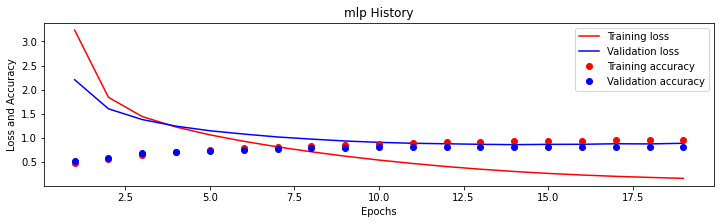

In [142]:
EPOCHS = 30
BATCH_SIZE = 64
name = 'mlp'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(file_path + '/model/best_{}.h5'.format(name), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mlp.compile(optimizer=Adam(lr=0.0004), loss='categorical_crossentropy', metrics=['accuracy'])

history = mlp.fit(tfidfv_train,
                  y_train,
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  validation_split=0.2, 
                  verbose=1,
                  callbacks = [es, mc]) 

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot 
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title(name+' History')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy')
plt.legend()

In [147]:
best_model = keras.models.load_model(file_path + '/model/best_{}.h5'.format(name))
best_model.evaluate(tfidfv_test, y_test, verbose=2)
predicted = best_model.predict(tfidfv_test)

print("정확도:", accuracy_score(y_test.argmax(axis=1), predicted.argmax(axis=1))) #예측값과 실제값 비교
print(classification_report(y_test.argmax(axis=1), predicted.argmax(axis=1)))

71/71 - 0s - loss: 0.9053 - accuracy: 0.7965
정확도: 0.796527159394479
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.78      0.77       105
           2       0.71      0.60      0.65        20
           3       0.93      0.93      0.93       813
           4       0.79      0.89      0.84       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.33      0.50         3
           8       0.62      0.68      0.65        38
           9       0.84      0.84      0.84        25
          10       0.84      0.90      0.87        30
          11       0.62      0.78      0.70        83
          12       0.75      0.23      0.35        13
          13       0.61      0.62      0.61        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16 

평가 Metric: [BLEU](https://wikidocs.net/31695)

## Vocab size = 5000개 사용 
* 빈도수 상위 5,000개의 단어만 사용

In [ ]:
vocab_size = 5000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

## Vocab size = 모든 단어 사용

In [ ]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(test_split=0.2)